In [1]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

import rasterio

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Running on device: {device}")

Running on device: cpu


In [3]:
csv_path = "/atlas/u/erikrozi/housing_event_pred/data/train_seasonal_eff.csv"
root_dir = "/atlas/u/pliu1/housing_event_pred/data/houses_new/"

In [57]:
df = pd.read_csv(csv_path).drop(["Unnamed: 0"], axis=1)
df

,year.built,eff.year.built,region,sentinel_2016_1,sentinel_2016_2,sentinel_2016_3,sentinel_2016_4,sentinel_2017_1,sentinel_2017_2,sentinel_2017_3,...,sentinel_2018_3,sentinel_2018_4,sentinel_2019_1,sentinel_2019_2,sentinel_2019_3,sentinel_2019_4,sentinel_2020_1,sentinel_2020_2,sentinel_2020_3,sentinel_2020_4
0,2018,2018,dallas,/atlas/u/pliu1/housing_event_pred/data/houses_...,/atlas/u/pliu1/housing_event_pred/data/houses_...,/atlas/u/pliu1/housing_event_pred/data/houses_...,/atlas/u/pliu1/housing_event_pred/data/houses_...,/atlas/u/pliu1/housing_event_pred/data/houses_...,/atlas/u/pliu1/housing_event_pred/data/houses_...,/atlas/u/pliu1/housing_event_pred/data/houses_...,...,/atlas/u/pliu1/housing_event_pred/data/houses_...,/atlas/u/pliu1/housing_event_pred/data/houses_...,/atlas/u/pliu1/housing_event_pred/data/houses_...,/atlas/u/pliu1/housing_event_pred/data/houses_...,/atlas/u/pliu1/housing_event_pred/data/houses_...,/atlas/u/pliu1/housing_event_pred/data/houses_...,/atlas/u/pliu1/housing_event_pred/data/houses_...,/atlas/u/pliu1/housing_event_pred/data/houses_...,/atlas/u/pliu1/housing_event_pred/data/houses_...,/atlas/u/pliu1/housing_event_pred/data/houses_...
1,2017,2017,houston,/atlas/u/pliu1/housing_event_pred/data/houses_...,/atlas/u/pliu1/housing_event_pred/data/houses_...,/atlas/u/pliu1/housing_event_pred/data/houses_...,/atlas/u/pliu1/housing_event_pred/data/houses_...,/atlas/u/pliu1/housing_event_pred/data/houses_...,/atlas/u/pliu1/housing_event_pred/data/houses_...,/atlas/u/pliu1/housing_event_pred/data/houses_...,...,/atlas/u/pliu1/housing_event_pred/data/houses_...,/atlas/u/pliu1/housing_event_pred/data/houses_...,/atlas/u/pliu1/housing_event_pred/data/houses_...,/atlas/u/pliu1/housing_event_pred/data/houses_...,/atlas/u/pliu1/housing_event_pred/data/houses_...,/atlas/u/pliu1/housing_event_pred/data/houses_...,/atlas/u/pliu1/housing_event_pred/data/houses_...,/atlas/u/pliu1/housing_event_pred/data/houses_...,/atlas/u/pliu1/housing_event_pred/data/houses_...,/atlas/u/pliu1/housing_event_pred/data/houses_...
2,2016,2016,houston,/atlas/u/pliu1/housing_event_pred/data/houses_...,/atlas/u/pliu1/housing_event_pred/data/houses_...,/atlas/u/pliu1/housing_event_pred/data/houses_...,/atlas/u/pliu1/housing_event_pred/data/houses_...,/atlas/u/pliu1/housing_event_pred/data/houses_...,/atlas/u/pliu1/housing_event_pred/data/houses_...,/atlas/u/pliu1/housing_event_pred/data/houses_...,...,/atlas/u/pliu1/housing_event_pred/data/houses_...,/atlas/u/pliu1/housing_event_pred/data/houses_...,/atlas/u/pliu1/housing_event_pred/data/houses_...,/atlas/u/pliu1/housing_event_pred/data/houses_...,/atlas/u/pliu1/housing_event_pred/data/houses_...,/atlas/u/pliu1/housing_event_pred/data/houses_...,/atlas/u/pliu1/housing_event_pred/data/houses_...,/atlas/u/pliu1/housing_event_pred/data/houses_...,/atlas/u/pliu1/housing_event_pred/data/houses_...,/atlas/u/pliu1/housing_event_pred/data/houses_...
3,2017,2017,austin,/atlas/u/pliu1/housing_event_pred/data/houses_...,/atlas/u/pliu1/housing_event_pred/data/houses_...,/atlas/u/pliu1/housing_event_pred/data/houses_...,/atlas/u/pliu1/housing_event_pred/data/houses_...,/atlas/u/pliu1/housing_event_pred/data/houses_...,/atlas/u/pliu1/housing_event_pred/data/houses_...,/atlas/u/pliu1/housing_event_pred/data/houses_...,...,/atlas/u/pliu1/housing_event_pred/data/houses_...,/atlas/u/pliu1/housing_event_pred/data/houses_...,/atlas/u/pliu1/housing_event_pred/data/houses_...,/atlas/u/pliu1/housing_event_pred/data/houses_...,/atlas/u/pliu1/housing_event_pred/data/houses_...,/atlas/u/pliu1/housing_event_pred/data/houses_...,/atlas/u/pliu1/housing_event_pred/data/houses_...,/atlas/u/pliu1/housing_event_pred/data/houses_...,/atlas/u/pliu1/housing_event_pred/data/houses_...,/atlas/u/pliu1/housing_event_pred/data/houses_...
4,2017,2017,austin,/atlas/u/pliu1/housing_event_pred/data/houses_...,/atlas/u/pliu1/housing_event_pred/data/houses_...,/atlas/u/pliu1/housing_event_pred/data/houses_...,/atlas/u/pliu1/housing_even

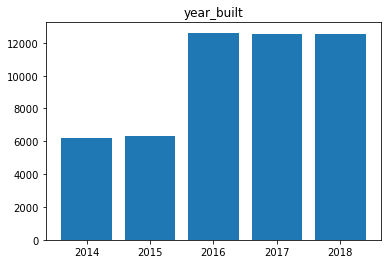

In [58]:
plt.bar(*np.unique(df["year.built"], return_counts=True))
plt.title("year_built")
plt.show()

In [59]:
df = df[df["year.built"].isin([2017, 2018])]
len(df)

25071

In [7]:
idx = 400
row = df.iloc[idx]
img_locs = row[df.columns.str.contains("sentinel_")].to_numpy()
images = torch.FloatTensor([rasterio.open(name).read() for name in img_locs])
build_year = row["year.built"]
images.shape

/tmp/ipykernel_3380871/2766146464.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272204863/work/torch/csrc/utils/tensor_new.cpp:201.)
  images = torch.FloatTensor([rasterio.open(name).read() for name in img_locs])


torch.Size([20, 4, 23, 27])

In [8]:
def show_image(image):
    plt.figure()
    max_clamp = 3000
    gamma = 1.2
    image = torch.Tensor(image[0:3]).permute(1, 2, 0).numpy()
    image = np.clip(image, 0, max_clamp) 
    image = (255 * (image / max_clamp)**(1/gamma)).astype(np.uint8)
    plt.imshow(image)
    plt.show()
    
def show_series(images):
    max_clamp = 3000
    gamma = 1.2
    fig, axs = plt.subplots(5,4,figsize=(12, 15))

    for i in range(images.shape[0]):
        image = images[i]
        image = torch.Tensor(image[0:3]).permute(1, 2, 0).numpy()
        image = np.clip(image, 0, max_clamp) 
        image = (255 * (image / max_clamp)**(1/gamma)).astype(np.uint8)
        axs[i // 4, i%4].imshow(image)
        axs[i // 4, i%4].axis('off')
        axs[i // 4, i%4].set_title(f"Year {i // 4 + 2016}, Month: {(i % 4) * 3 + 1}")
    plt.show()
#show_series(img_loc[0])

Build year: 2018


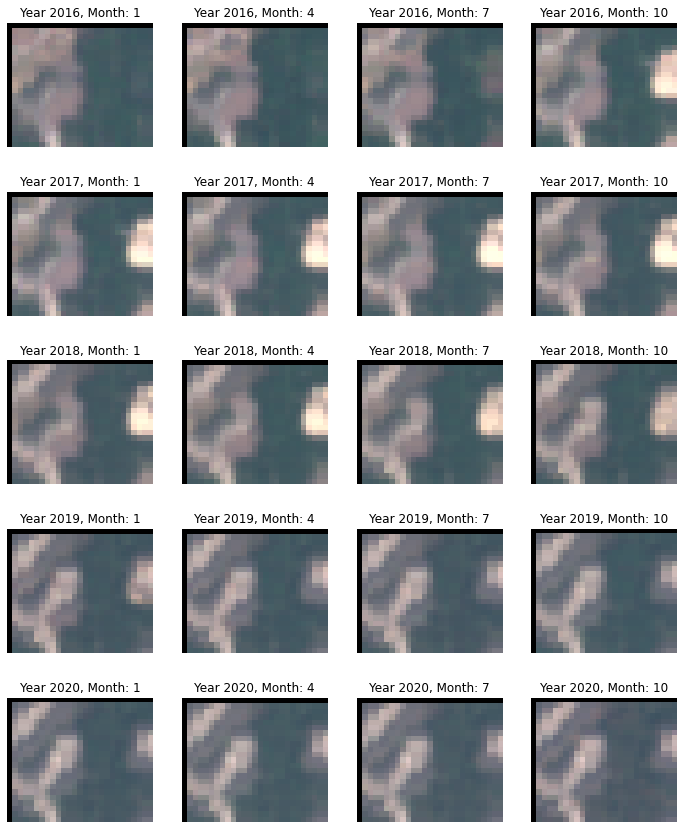

In [9]:
print("Build year:", build_year)
show_series(images)

In [10]:
label = 1 * (np.random.rand() < 0.5) # 0 for sampled image before construction year, 1 for after
print("Label:", label)
print("Build year:", build_year)
before_times = [(year, month) for year in range(2016, build_year) for month in range(1, 12, 3)]
after_times = [(year, month) for year in range(build_year+1, 2020) for month in range(1, 12, 3)]
if label == 0: # Start -> Sampled -> Build -> End
    T_start, T_sample = sorted(np.random.choice(np.arange(len(before_times)), size=(2,), replace=False))
    T_end = np.random.choice(np.arange(len(after_times)), replace=False)
    T_start = before_times[T_start]
    T_end = after_times[T_end]
    T_sample = before_times[T_sample]
else:
    T_start = np.random.choice(np.arange(len(before_times)), replace=False)
    T_sample, T_end = sorted(np.random.choice(np.arange(len(after_times)), size=(2,), replace=False))
    T_start = before_times[T_start]
    T_end = after_times[T_end]
    T_sample = after_times[T_sample]
print(f"Start {T_start} -> Sample {T_sample} -> End {T_end}")

Label: 1
Build year: 2018
Start (2017, 1) -> Sample (2019, 7) -> End (2019, 10)


In [11]:
col_names = [f"sentinel_{y}_{(m - 1) // 3 + 1}" for y, m in [T_start, T_end, T_sample]]
image_files = row[col_names].tolist()
image_files

['/atlas/u/pliu1/housing_event_pred/data/houses_new/2017_1_2026024_austin.tif',
 '/atlas/u/pliu1/housing_event_pred/data/houses_new/2019_4_2026024_austin.tif',
 '/atlas/u/pliu1/housing_event_pred/data/houses_new/2019_3_2026024_austin.tif']

Start (2017, 1)


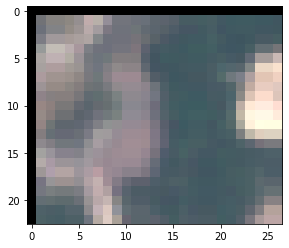

End (2019, 10)


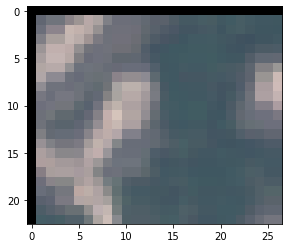

Sample (2019, 7)


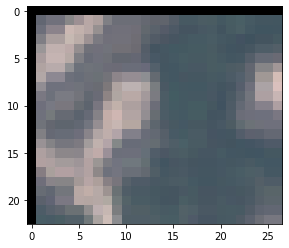

In [12]:
img_start, img_end, img_sample = torch.FloatTensor([rasterio.open(name).read() for name in image_files])
print("Start", T_start)
show_image(img_start)
print("End", T_end)
show_image(img_end)
print("Sample", T_sample)
show_image(img_sample)

# Housing dataset class

In [53]:
class HousingDataset(torch.utils.data.Dataset):
    '''Housing Dataset, Seasonal Sentinel-2'''
    def __init__(self, 
                 csv_file = "/atlas/u/erikrozi/housing_event_pred/data/train_seasonal_eff.csv",
                 root_dir = "/atlas/u/pliu1/housing_event_pred/data/houses_new/", 
                 first_year = 2016,
                 last_year = 2019,
                 build_years = [2017, 2018], 
                 transform = None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            first_year (int): Earliest year to allow images from.
            last_year (int): Last year to allow images from.
            build_years (list of ints): List of all build years to use.
            transform (callable, optional): Optional transform to be applied on tensor images.
        """
        self.df = pd.read_csv(csv_file)
        self.df = self.df[self.df["year.built"].isin(build_years)]
        self.root_dir = root_dir
        self.transform = transform
        
        self.first_year = first_year
        self.last_year = last_year
        
        # Gets all unique image ids
        self.image_ids = self.df.iloc[:, 0].to_numpy()
        
    def __len__(self):
        return len(self.image_ids)
    
    def __getitem__(self, idx):
        '''Gets timeseries info for images in one area
        
        Args: 
            idx: Index of datapoint in dataset
            
        Returns dictionary containing:
            'id' (int): ID of image location
            'region' (str): Region of image location
            'year_built' (int): Year built as labeled in dataset
            'label' (int, 0 or 1): 0 if sampled image occurs before the build year, 1 if it occurs after
            'image_start' (torch.FloatTensor): Image at the start time
            'year_start' (int): Year of the start image 
            'month_start' (month): Month of the start date
            'image_end' (torch.FloatTensor): Image at the end time. Without transfermations, should have dimensions
                ChannelxHeightxWidth, with channel order R, G, B, B8 (NIR)
            'year_end' (int): Year of the end image 
            'month_end' (month): Month of the end date
            'image_sample' (torch.FloatTensor): Image at the sample time
            'year_sample' (int): Year of the sample image 
            'month_sample' (month): Month of the sample date
        '''
        row = self.df.iloc[idx]
        year_built = row["year.built"]
        
        label = 1 * (np.random.rand() < 0.5) # 0 for sampled image before construction year, 1 for after
        before_times = [(year, month) for year in range(self.first_year, year_built) for month in range(1, 12, 3)]
        after_times = [(year, month) for year in range(year_built+1, self.last_year+1) for month in range(1, 12, 3)]
        if label == 0: # Start -> Sampled -> Build -> End
            T_start, T_sample = sorted(np.random.choice(np.arange(len(before_times)), size=(2,), replace=False))
            T_end = np.random.choice(np.arange(len(after_times)), replace=False)
            T_start = before_times[T_start]
            T_end = after_times[T_end]
            T_sample = before_times[T_sample]
        else: # Start-> Build -> Sampled -> End
            T_start = np.random.choice(np.arange(len(before_times)), replace=False)
            T_sample, T_end = sorted(np.random.choice(np.arange(len(after_times)), size=(2,), replace=False))
            T_start = before_times[T_start]
            T_end = after_times[T_end]
            T_sample = after_times[T_sample]
            
        col_names = [f"sentinel_{y}_{(m - 1) // 3 + 1}" for y, m in [T_start, T_end, T_sample]]
        image_files = row[col_names].tolist()
        
        images = torch.FloatTensor([rasterio.open(name).read() for name in image_files])  

        if self.transform:
            images = self.transform(images)
            
        img_start, img_end, img_sample = images
            
        return {
            'id': int(self.image_ids[idx]),
            'region': self.df.iloc[idx, :]['region'],
            'year_built': year_built,
            'label': label,
            'image_start': img_start,
            'year_start': T_start[0],
            'month_start': T_start[1],
            'image_end': img_end,
            'year_end': T_end[0],
            'month_end': T_end[1],
            'image_sample': img_sample,
            'year_sample': T_sample[0],
            'month_sample': T_sample[1],
        }

In [54]:
class Select(torch.nn.Module):
    """
    Selects channels by index along given dimension.
    
    Args:
        dim (int) - Dimension to select along
        indices (list of int) - Indices to keep
    """
    def __init__(self,
                 dim=-3,
                 indices=[0,1,2]):
        super(Select, self).__init__()
        self.dim = dim
        self.indices = indices
    
    def forward(self, x):
        x = x.transpose(0, self.dim)
        x = x[self.indices]
        x = x.transpose(0, self.dim)
        return x
   
class CustomScale(torch.nn.Module):
    """
    Applies affine transformation each value in a tensor, and applies a clamp.
    
    Args:
        scale (float): Value to multiply each tensor value by
        shift (float): Constant to add to scaled values
        clamp (2-tuple of float or None): Lower and upper bounds to clamp to,
            None for no clamping
    """
    def __init__(self,
                 scale=1/6400,
                 shift=0,
                 clamp=(0.0, 1.0)
                ):
        super(CustomScale, self).__init__()
        self.scale = scale
        self.shift = shift
        self.clamp = clamp
    
    def forward(self, x):
        return (x * self.scale + self.shift).clamp(self.clamp[0], self.clamp[1])

In [55]:
SCALE = 2**16
norm_mean=np.array([1377, 1354, 1381, 2356]) / SCALE
norm_std=np.array([540, 398, 327, 515]) / SCALE
    
transformations = [
    transforms.CenterCrop(size=(32, 32)), 
    CustomScale(scale=1/SCALE, clamp=(0, 1.0)),
    transforms.Normalize(mean=norm_mean, std=norm_std),
    Select(dim=-3, indices=[0,1,2]),
]
transform = transforms.Compose(transformations)

reverse_transform = transforms.Normalize(mean=-norm_mean[:3]/norm_std[:3], std=1/norm_std[:3]/SCALE)

In [48]:
train_set = HousingDataset(transform=transform)

In [49]:
datapoint = train_set[0]

Year built 2018
Label 0
Start 2016 7


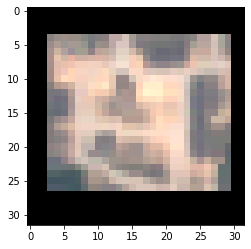

End 2019 4


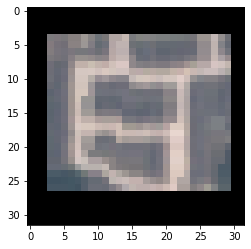

Sample 2016 10


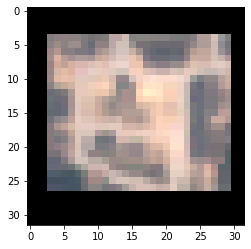

In [50]:
print("Year built", datapoint['year_built'])
print("Label", datapoint['label'])
print("Start", datapoint['year_start'], datapoint['month_start'])
show_image(reverse_transform(datapoint['image_start']))
print("End", datapoint['year_end'], datapoint['month_end'])
show_image(reverse_transform(datapoint['image_end']))
print("Sample", datapoint['year_sample'], datapoint['month_sample'])
show_image(reverse_transform(datapoint['image_sample']))

In [51]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=4, shuffle=True)

In [103]:
batch = next(iter(train_loader))

In [122]:
def show_batch(batch, reverse_transform=None):
    def revert(images):
        max_clamp = 3000
        gamma = 1.2
        if reverse_transform:
            images = reverse_transform(images)
        images = images.permute((0,2,3,1)).cpu().numpy()
        images = np.clip(images, 0, max_clamp)
        return (255 * (images / max_clamp)**(1/gamma)).astype(np.uint8)
    
    B, C, H, W = batch["image_start"].shape
    image_start = revert(batch["image_start"])
    image_end = revert(batch["image_end"])
    image_sample = revert(batch["image_sample"])
    for i in range(B):
        print(batch["id"][i].item(), batch["region"][i])
        plt.figure(figsize=(15, 5))
        canvas = np.ones((H, W*3 + 40, C)) * 255
        left = 0
        canvas[:, left:left+W, :] = image_start[i]
        x = []
        x.append((left + W // 2, f"Start {batch['year_start'][i]} month {batch['month_start'][i]}"))
        left += W+10
        if batch["label"][i] == 0:
            canvas[:, left:left+W, :] = image_sample[i]
            x.append((left + W // 2, f"Sample {batch['year_sample'][i]} month {batch['month_sample'][i]}"))
            left += W+10
            canvas[:, left:left+10, :] = [128,0,0]
            x.append((left + 5, f"Built {batch['year_built'][i]}"))
            left += 20
        else:
            canvas[:, left:left+10, :] = [128,0,0]
            x.append((left + 5, f"Built {batch['year_built'][i]}"))
            left += 20
            canvas[:, left:left+W, :] = image_sample[i]
            x.append((left + W // 2, f"Sample {batch['year_sample'][i]} month {batch['month_sample'][i]}"))
            left += W+10
        canvas[:, left:left+W, :] = image_end[i]
        x.append((left + W // 2, f"End {batch['year_end'][i]} month {batch['month_end'][i]}"))
        
        xticks, xlabels = zip(*x)
        plt.xticks(ticks=xticks, labels=xlabels, fontsize=15)
        plt.imshow(canvas.astype(np.uint8))
        plt.show()

2108489 austin


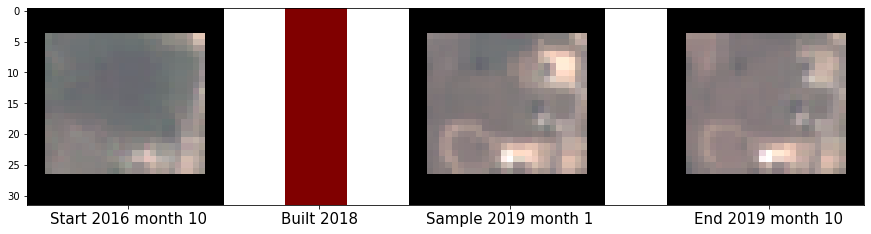

3912834 dallas


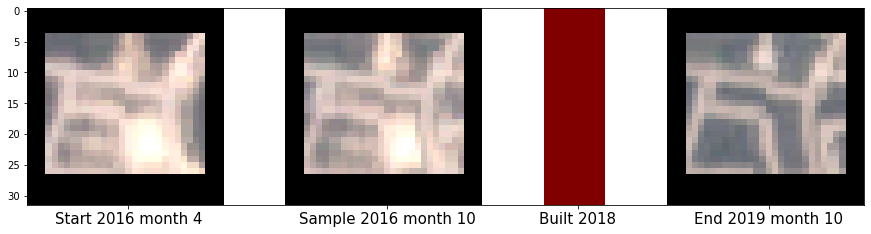

6442695 austin


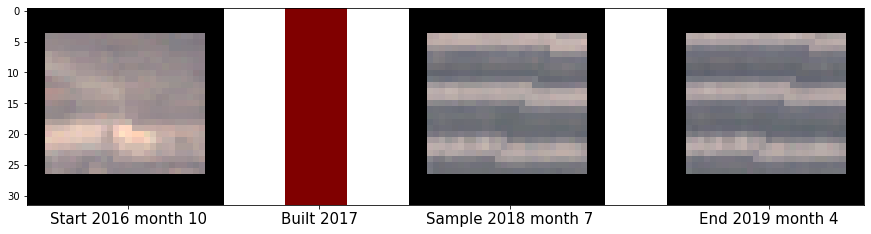

3913300 dallas


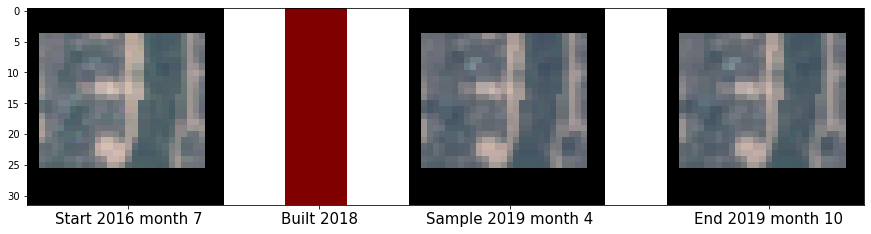

In [123]:
show_batch(batch, reverse_transform)